In [186]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

In [187]:
df = pd.read_csv(r'...\cereal_rating.csv')

In [188]:
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbs,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


In [189]:
#One Hot-Encode Hot and Cold
df['cold'] = np.where(df.type=='C', 1, 0)

In [190]:
nums = df.loc[:, (df.dtypes == np.float64) | (df.dtypes == np.int64)]
nums.describe()

,calories,protein,fat,sodium,fiber,carbs,sugars,potass,vitamins,shelf,weight,cups,rating
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,106.883117,2.545455,1.012987,159.675325,2.151948,14.597403,6.922078,96.077922,28.246753,2.207792,1.029610,0.821039,42.665705
std,19.484119,1.094790,1.006473,83.832295,2.383364,4.278956,4.444885,71.286813,22.342523,0.832524,0.150477,0.232716,14.047289
min,50.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,0.500000,0.250000,18.042851
25%,100.000000,2.000000,0.000000,130.000000,1.000000,12.000000,3.000000,40.000000,25.000000,1.000000,1.000000,0.670000,33.174094
50%,110.000000,3.000000,1.000000,180.000000,2.000000,14.000000,7.000000,90.000000,25.000000,2.000000,1.000000,0.750000,40.400208
75%,110.000000,3.000000,2.000000,210.000000,3.000000,17.000000,11.000000,120.000000,25.000000,3.000000,1.000000,1.000000,50.828392
max,160.000000,6.000000,5.000000,320.000000,14.000000,23.000000,15.000000,330.000000,100.000000,3.000000,1.500000,1.500000,93.704912


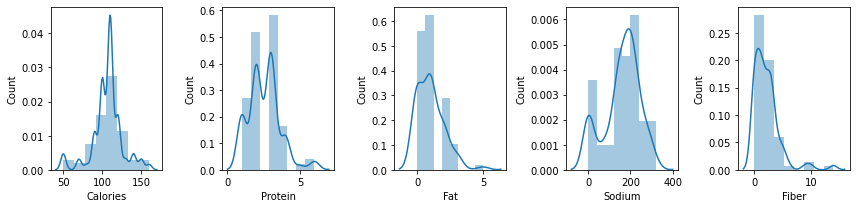

In [191]:
figure, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 3))
y = 0
for col in list(nums.columns)[0:5]:
    sns.distplot(df[col], ax=axes[y], bins=int(np.sqrt(len(df[col]))))
    axes[y].set_ylabel('Count')
    axes[y].set_xlabel(col.title())
    y+=1
figure.tight_layout()
plt.show()

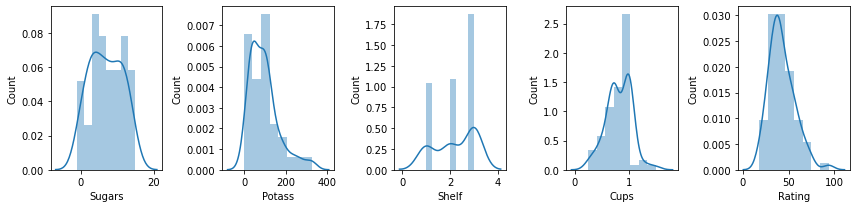

In [192]:
nums = nums.drop(['weight', 'vitamins'], axis = 1)
figure, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 3))
y = 0
for col in list(nums.columns)[6:11]:
    sns.distplot(df[col], ax=axes[y], bins=int(np.sqrt(len(df[col]))))
    axes[y].set_ylabel('Count')
    axes[y].set_xlabel(col.title())
    y+=1
figure.tight_layout()
plt.show()

In [193]:
obs = df.loc[:, df.dtypes == object]
obs.describe().transpose()

,count,unique,top,freq
name,77,77,Frosted Flakes,1
mfr,77,7,K,23
type,77,2,C,74


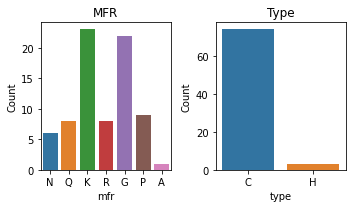

In [194]:
figure, axes = plt.subplots(nrows=1, ncols = 2, figsize=(5, 3))
sns.countplot(df.mfr, ax=axes[0])
axes[0].set_title('MFR')
axes[0].set_ylabel('Count')
sns.countplot(df.type, ax =axes[1])
axes[1].set_title('Type')
axes[1].set_ylabel('Count')
figure.tight_layout()
plt.show()
# pd.DataFrame(df.mfr.value_counts(normalize=True))

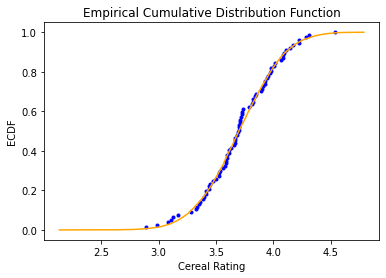

In [195]:
x = np.sort(np.log(df.rating.values))
y = np.arange(1, len(x)+1) / len(x)

#Create Theoretical Normal Distribution to Check if Data is Normal
nu = x.mean()
sig = x.std()
samples = np.random.normal(nu, sig, 10000)
x_theor = np.sort(samples)
y_theor = np.arange(1, len(samples)+1) / len(samples)

#Plot to Compare
plt.plot(x, y, marker='.', linestyle='none', color='blue')
plt.plot(x_theor, y_theor, color='orange')
plt.title('Empirical Cumulative Distribution Function')
plt.ylabel('ECDF')
plt.xlabel('Cereal Rating')
plt.show()

In [196]:
y = np.log(df['rating'])
X = df.drop(['rating', 'name', 'mfr', 'type'], axis = 1)

In [197]:
#Calculate VIF for each predictor
vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif['features'] = X.columns
vif

,vif,features
0,316.649280,calories
1,16.265504,protein
2,6.665728,fat
3,6.928381,sodium
4,16.402850,fiber
5,67.513398,carbs
6,21.253609,sugars
7,24.285987,potass
8,3.611802,vitamins
9,11.486275,shelf


In [198]:
#remove columns until vif < 10
while vif['vif'].max() > 10:
    X = X.drop(vif.loc[vif.vif==vif.vif.max(), 'features'], axis = 1)
    vif = pd.DataFrame()
    vif['vif'] = [variance_inflation_factor(X.values, k) for k in range(len(X.columns))]
    vif['features'] = X.columns
vif

,vif,features
0,9.193321,protein
1,2.756027,fat
2,5.232061,sodium
3,3.276281,fiber
4,4.058912,sugars
5,3.544630,vitamins
6,8.902527,shelf
7,8.897733,cups


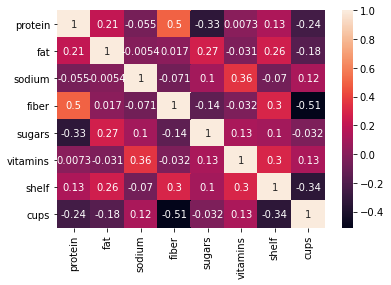

In [199]:
sns.heatmap(X.corr(), annot=True)
plt.show()

In [200]:
linreg = LinearRegression()

rsq_reg = cross_val_score(linreg, X, y, cv=10).mean()

In [201]:
#split our data into a training set and a hold out set to evaluate after grid search cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=142)

In [202]:
ridge = Ridge()
param_grid = {'alpha':np.arange(0, 20.1, 0.1)}

ridge_cv = GridSearchCV(ridge, param_grid, cv = 5)
ridge_cv.fit(X_train, y_train)
alph = ridge_cv.best_params_['alpha']
print(f"Alpha Parameter: {alph}")

ridge = Ridge(alpha=alph)
rsq_ridge = cross_val_score(ridge, X_test, y_test, cv = 5).mean()

Alpha Parameter: 1.4000000000000001


In [203]:
ridge_cv.best_score_

0.8348389989120093

In [204]:
tree = DecisionTreeRegressor(random_state=142)
param_grid = {'criterion':['mse', 'friedman_mse', 'mae'],
             'max_depth':np.arange(1, 30)}

tree_cv = GridSearchCV(tree, param_grid, cv = 5)
tree_cv.fit(X_train, y_train)
crit, max_d = tree_cv.best_params_.values()
print(f"Criteria: {crit} | Max Depth: {max_d}")

tree = DecisionTreeRegressor(criterion=crit, max_depth=max_d)
rsq_tree = cross_val_score(tree, X_test, y_test, cv = 5).mean()

Criteria: friedman_mse | Max Depth: 5


In [205]:
tree_cv.best_score_

0.6626536787228423

In [206]:
rf = RandomForestRegressor(random_state=142)
param_grid = {'n_estimators': [100, 500, 750, 1000],
             'max_features': ['auto', 'sqrt'],
             'bootstrap': [True, False]}

rf_cv = GridSearchCV(rf, param_grid, cv =5)
rf_cv.fit(X_train, y_train)
boot, max_f, n_est = rf_cv.best_params_.values()
print(f"Estimators: {n_est} | Max Features: {max_f} | Bootsrapping: {boot}")

rf = RandomForestRegressor(n_estimators=n_est, max_features = max_f, bootstrap = boot)
rsq_forest = cross_val_score(rf, X_test, y_test, cv = 5).mean()

Estimators: 1000 | Max Features: sqrt | Bootsrapping: False


In [207]:
rf_cv.best_score_

0.8279758351670143

In [208]:
print('Linear Regression: {}'.format(round(rsq_reg, 3)))
print('Ridge Regression: {}'.format(round(rsq_ridge, 3)))
print('Decision Tree: {}'.format(round(rsq_tree, 3)))
print('Random Forest: {}'.format(round(rsq_forest, 3)))

Linear Regression: 0.765
Ridge Regression: 0.788
Decision Tree: 0.434
Random Forest: 0.455
